# French Rap Lyrics Generator using LSTM

## Preprocessing

### Import the necessary libraries

In [59]:
from tqdm import tqdm 
import numpy as np
import glob
import os

### Importing data set

In [60]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# getting all rappers files recursivly
lyrics_files = glob.glob('/content/drive/MyDrive/french_rap_lyrics/*.txt')

Mounted at /content/drive/


### Splitting the text of the lyrics

In [61]:
# splitting the text lyrics into words
lyrics_corpus = []
for file in tqdm(lyrics_files, position=0, leave=True):
    with open(file) as f :
      lyrics = f.read().lower().replace('\n', ' \n ')
      lyrics_words = [word for word in lyrics.split(' ') if word.strip() != '' or word == '\n']
      lyrics_corpus = lyrics_corpus + lyrics_words

100%|██████████| 135/135 [00:06<00:00, 20.55it/s]


In [62]:
print("Number of words in the lyrics corpus:", len(lyrics_corpus))

Number of words in the lyrics corpus: 3755571


### Cleaning the lyrics

In [63]:
# words that appear less than 10 times are removed
MIN_WORD_FREQ = 10

# set of all the words in the lyrics
word_freq = {}
for word in lyrics_corpus:
    word_freq[word] = word_freq.get(word, 0) + 1

# set of all the words we want to remove
ignored_words = set()
for key, value in word_freq.items():
    if word_freq[key] < MIN_WORD_FREQ:
        ignored_words.add(key)

In [64]:
# displaying size of data set before cleaning and condition of removal
words = set(lyrics_corpus)
print('Number of unique words before removing:', len(words))
print('Removing words with frequency <', MIN_WORD_FREQ)

# displaying size of data set after cleaning
words = sorted(set(words) - ignored_words)
print('Number of unique words after removing:', len(words))

Number of unique words before removing: 197945
Removing words with frequency < 10
Number of unique words after removing: 22353


In [65]:
# set of words with index as value
word_index = dict((c, i) for i, c in enumerate(words))
# set of words with index as key
index_word = dict((i, c) for i, c in enumerate(words))

In [66]:
STEP = 4 # number of words needed to generate one new word
SEQ_LEN = 15 # length of the sequence used to generate new sequence

prev_words = []
next_words = []
ignored = 0

for i in tqdm(range(0, len(lyrics_corpus) - SEQ_LEN, STEP), position=0, leave=True):
    # adding sequences where no word needs to be removed
    if len(set(lyrics_corpus[i: i + SEQ_LEN + 1]).intersection(ignored_words)) == 0:
        prev_words.append(lyrics_corpus[i: i + SEQ_LEN])
        next_words.append(lyrics_corpus[i + SEQ_LEN])
    # moving to next sequence if there's words to remove
    else:
        ignored += 1

100%|██████████| 938889/938889 [00:03<00:00, 268517.05it/s]


In [67]:
# display the size of ignored and remaining sequences
print('Number of ignored sequences:', ignored)
print('Number of remaining sequences:', len(prev_words))

Number of ignored sequences: 671348
Number of remaining sequences: 267541


### Shuffling and splitting the lyrics

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
def shuffle_and_split_training_set(prev_seq, next_seq, percentage_test = 2):
    tmp_prev_word = []
    tmp_next_word = []

    # shuffling the data set
    for i in np.random.permutation(len(prev_seq)):
        tmp_prev_word.append(prev_seq[i])
        tmp_next_word.append(next_seq[i])

    # splitting data set into traning data and test data
    split_index = int(len(prev_seq) * (1.-(percentage_test/100.)))
    X_train, X_test = tmp_prev_word[:split_index], tmp_prev_word[split_index:]
    y_train, y_test = tmp_next_word[:split_index], tmp_next_word[split_index:]

    # displaying the size of traning data and test data
    print("Number of words in the training data set:", len(X_train))
    print("Number of words in the test data set:", len(y_test))

    return (X_train, y_train), (X_test, y_test)

In [70]:
# applying shuffle and split function to our data set
(prev_words_train, next_words_train), (prev_words_test, next_words_test) = shuffle_and_split_training_set(prev_words, next_words)

Number of words in the training data set: 262190
Number of words in the test data set: 5351


## Processing

### Building the neural network

In [71]:
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping           
from keras.models import Sequential                                                  
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding

In [72]:
# linear stack of layers
model = Sequential()

# word embedding layers
model.add(Embedding(input_dim=len(words), output_dim=512))

# input flow backwards and forward
model.add(Bidirectional(LSTM(128)))

# to avoid overfitting we randomly drop out units during training
model.add(Dropout(0.2))

# layers for changing vectors dimensions
model.add(Dense(len(words)))

# using normalized exponential as activation function
model.add(Activation('softmax'))

# using cross-entropy as loss function
# using adaptive moment estimation algorithm to optimze results
# using the accuracy of the model as metric
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# display the model parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 512)         11444736  
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 22353)             5744721   
                                                                 
 activation_1 (Activation)   (None, 22353)             0         
                                                                 
Total params: 17,845,841
Trainable params: 17,845,841
Non-trainable params: 0
__________________________________________

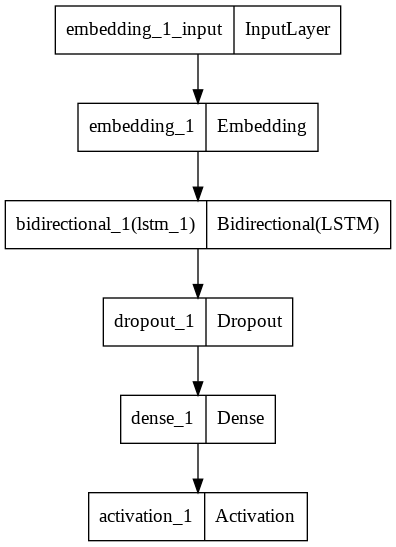

In [73]:
# display the model as a graph
import tensorflow as tf
tf.keras.utils.plot_model(model)

### Building data generator

In [74]:
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from operator import itemgetter

In [75]:
# function to generate data from our data set in order to feed our model
def generator(prev_word_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, SEQ_LEN), dtype=np.int32)
        y = np.zeros((batch_size), dtype=np.int32)
        for i in range(batch_size):
            for t, w in enumerate(prev_word_list[index % len(prev_word_list)]):
                x[i, t] = word_index[w]
            y[i] = word_index[next_word_list[index % len(prev_word_list)]]
            index = index + 1
        yield x, y

### Traning the model

In [76]:
BATCH_SIZE = 32

file_path = 'french_rap_lyrics/Modelbis'

# regularization to avoid overfitting because our model is iterative
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# serialization of our network each time there is an improvement during training
model_checkpoint = ModelCheckpoint(filepath=file_path + '.hdf5', monitor='val_accuracy', save_best_only=True)

callbacks_list = [early_stopping, model_checkpoint]

# training the model by passing the training dataset 10 times through the neural network
model.fit(generator(prev_words, next_words, BATCH_SIZE),
                        steps_per_epoch=int(len(prev_words)/BATCH_SIZE) + 1,
                        epochs=10,
                        callbacks=callbacks_list,
                        validation_data=generator(prev_words_test, next_words_test, BATCH_SIZE),
                        validation_steps=int(len(prev_words_test)/BATCH_SIZE) + 1)

Epoch 1/10
8361/8361 [==============================] - 2334s 279ms/step - loss: 6.4347 - accuracy: 0.1363 - val_loss: 5.6055 - val_accuracy: 0.1717
Epoch 2/10
8361/8361 [==============================] - 2408s 288ms/step - loss: 5.4675 - accuracy: 0.1756 - val_loss: 4.9813 - val_accuracy: 0.2070
Epoch 3/10
8361/8361 [==============================] - 2531s 303ms/step - loss: 4.8642 - accuracy: 0.2046 - val_loss: 4.4367 - val_accuracy: 0.2524
Epoch 4/10
8361/8361 [==============================] - 2310s 276ms/step - loss: 4.2968 - accuracy: 0.2460 - val_loss: 3.9290 - val_accuracy: 0.3082
Epoch 5/10
8361/8361 [==============================] - 2464s 295ms/step - loss: 3.7626 - accuracy: 0.3031 - val_loss: 3.4658 - val_accuracy: 0.3583
Epoch 6/10
8361/8361 [==============================] - 2352s 281ms/step - loss: 3.3062 - accuracy: 0.3619 - val_loss: 3.0944 - val_accuracy: 0.4116
Epoch 7/10
8361/8361 [==============================] - 2463s 295ms/step - loss: 2.9273 - accuracy: 0.4150

## Testing

### Initial input seed

In [107]:
seed_index = np.random.randint(len(prev_words))
seed = ['ce', 'son', 'est', 'écrit', 'par', 'un', 'robot', '\n', 'eh', 'oui', 'le', 'son', 'vient', 'de', 'la', 'rue', 'gros']
print(seed)

['ce', 'son', 'est', 'écrit', 'par', 'un', 'robot', '\n', 'eh', 'oui', 'le', 'son', 'vient', 'de', 'la', 'rue', 'gros']


### Index sample

In [78]:
def sample(preds, temperature):
    # converting predictions values to array
    preds = np.asarray(preds).astype('float64')
    # modifying predictions values
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # generating multinomial distribution following predictions
    probas = np.random.multinomial(1, preds, 1)
    # returning index of maximum values
    return np.argmax(probas)

### Generating french rap lyrics

In [113]:
for temperature in [0.1, 0.3, 0.5, 0.7, 0.9]:
    # initializing the sentence with our seed
    sentence = seed
    lyrics = []

    for i in range(150):
        # initializing the prediction variable
        X_pred = np.zeros((1, SEQ_LEN))
        for t, word in enumerate(sentence):
            X_pred[0, t-2] = word_index[word]

        # making our predictions on lyrics
        preds = model.predict(X_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_word = index_word[next_index]

        # removing the first word from the beginning the sentence
        sentence = sentence[1:]
        # adding the new word generated at the end of the sentence
        sentence.append(next_word)
        # adding the new word generated to the list of lyrics
        lyrics.append(next_word)

    # displaying all the lyrics generated following our intial seed
    print('Génération pour la température', temperature, ':\n')
    print(' '.join(seed))
    print(' '.join(lyrics))
    print('\n')

Génération pour la température 0.1 :

ce son est écrit par un robot 
 eh oui le son vient de la rue gros

 tu peux pas prendre ce qu'ils ont des gros pour les groupies 
 les groupies sont loué belle, les soirs, ils sont des liasses et dans le refaire le regard est le même 
 le monde est à la base, on a la santé et on sait qui 
 on a pas facile à nous on sait 
 on sait pas qu'on est 
 on est pas dans la merde 
 on sait pas qu'on est 
 on a pas besoin de faire 
 on se dit qu'j'étais ce que je suis pas fier 
 mais quand on peut pas tout perdre, j'essaie de faire 
 j'ai de l'amour pour une villa sur le dos 
 mon rap est un truc avant que mon mère 
 je le vois le monde pour les miens 
 si je ne me fais pas le temps pour faire le temps 
 si


Génération pour la température 0.3 :

ce son est écrit par un robot 
 eh oui le son vient de la rue gros

 j'suis pas là pour les lovés, plus de foi 
 plus de gamin 
 pas de trop froid pour les faire des euros, trop mourir sans parler 
 en mode de balle